# Pronóstico del consumo de electricidad
***Por: Leonel Mera ft Jose L. Zúñiga***

Las smart grids o redes eléctricas inteligentes son una forma de gestión eficiente de la electricidad. El término empezó a utilizarse en el año 2003 aunque su primera aparición data del año 1998. La definición de una smart grid o red eléctrica inteligente es la aplicación de procesamiento digital y comunicaciones a la red eléctrica, haciendo que los datos fluyan por la red y que la gestión de la información sea el punto primordial de cualquier smart grid o red eléctrica inteligente.

Una de las funcionalidades basicas de este concepto técnologico es la medición de la tendencia de consumo eléctrico en una residencia convencional. La adquisición de datos que permitan el análisis de modelos que permitan determinar las tendencias de consumo son de gran importancia. El conjunto de datos compartido en el repositorio UCI *(Individual household electric power consumption Data Set)*, presenta Mediciones del consumo de energía eléctrica en un hogar con una tasa de muestreo de un minuto durante un período de casi 4 años. 

El conjunto de datos es de carácter multivariado, cuenta con una serie multivariada que consta de siete variables (además de la fecha y la hora); son:

- **global_active_power :** la potencia activa total consumida por el hogar (kilovatios).
- **global_reactive_power :** la potencia reactiva total consumida por el hogar (kilovatios).
- **voltaje :** voltaje promedio (voltios).
- **global_intensity :** Intensidad media actual (amperios).
- **sub_metering_1 :** Energía activa para la cocina (vatios-hora de energía activa).
- **sub_metering_2 :** Energía activa para lavandería (vatios-hora de energía activa).
- **sub_metering_3 :** Energía activa para sistemas de control de clima (vatios-hora de energía activa).
- **sub_metering_remainder :** La medición remanente es la energía restante en el consumo global de la residencia que no puede ser explicada a partir de las energía consumida por las otras tres secciones de la casa con medición individual.

Además, la base de datos cuenta con la marca de tiempo en el que se recopilaron los datos.

## Objetivo del proyecto

Los objetivos generales del proyecto es determinar el modelo basado en redes neuronales recurrentes que mejor se ajuste como predictor del consumo de energía en el futuro. El conjunto de datos se abordará como sistema predictor del consumo eléctrico para los próximos días de consumo eléctrico. 

## Proceso 

El presente notbook plantea los siguientes pasos para obtener el objetivo planteado:

**1. Preparación de los datos :** Los datos deberán ser reformados para eliminar datos faltantes y dejarlos en formato de medición de las variables por día.

**2. Análisis visual de los datos :** El análisis visual de los datos puede dar una noción preliminar de los posibles resultados a los que se desea llegar en las predicciones de la tendencia de los datos de consumo eléctrico.

**3. Evaluación de diferentes arquitecturas :** El proceso que se plantea en este proyecto tiene como finalidad determinar no solo el rendimiento de una arquitectura de red neuronal recurrente, buscamos determinar cuál de las arquitecturas planteadas tiene una mejor aproximación a la tendencia del consumo eléctrico en una residencia. Las arquitecturas planteadas son:

    - Redes neuronales recurrentes RNN
    - Redes neuronales con memoria a largo y corto plazo LSTM
    - Redes neuronales recurrentes cerradas GRU
    - Se evaluaran estas arquitecturas como auto encoder
    
**3.1. Pasos hacia atrás :** Las diferentes arquitecturas cuentas con diferentes pasos hacia atrás que buscan determinar el consumo eléctrico del próximo día. Las redes se entrenaron desde 1 hasta 30 días hacia atrás, se eligieron estos valores para las ventanas de los días buscando cubrir la mayor variabilidad de los días y los meses que pudiesen aportar información del consumo eléctrico. 

**4. Gráficos :** Los gráficos presentan información de las diferentes respuestas del modelo, se eligió el error cuadrático medio o RSM para verificar el ajuste del modelo y una grafica comparativa de ajuste de los datos para verificar visualmente la calidad de ajuste obtenida en las etapas de ajuste o entrenamiento y la etapa de pruebas. 

**5. Conclusiones :** Finalmente se presentaran conclusiones a partir de la valoración de las respuestas de las diferentes arquitecturas implementadas como método de ajuste de modelo predictivo.


## Librerías de análisis y de arquitectura

In [1]:
#Descargar datos
import os.path as path
if path.exists('household_power_consumption.csv'):   
    print ('Los datos ya existen')
else:
    !wget -nc https://www.dropbox.com/s/to294e4u0x7llo0/household_power_consumption.zip?dl=1
    !unzip household_power_consumption.zip?dl=1 | awk 'BEGIN { ORS = "" } { print "*" }'
    !rm -r household_power_consumption.zip?dl=1

Los datos ya existen


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from numpy import nan
from pandas import read_csv
%matplotlib inline
from pandas import read_csv

Using TensorFlow backend.


## 1. Cargar los datos

Los datos se encuentran en el repositorio UCI.

Como el conjunto de datos cuenta con espacios vacíos se llenan estos espacios con los mismos valores detectados en el día anterior.

Finalmente se crea un archivo .csv que será el archivo que se utilizara para procesarlo

### Presentando los datos 

A continuación se presentan las diferentes *señales* que hacen parte del conjunto de datos. Los datos presentan un muestreo por cada minuto para cada variable a lo largo de 4 años.

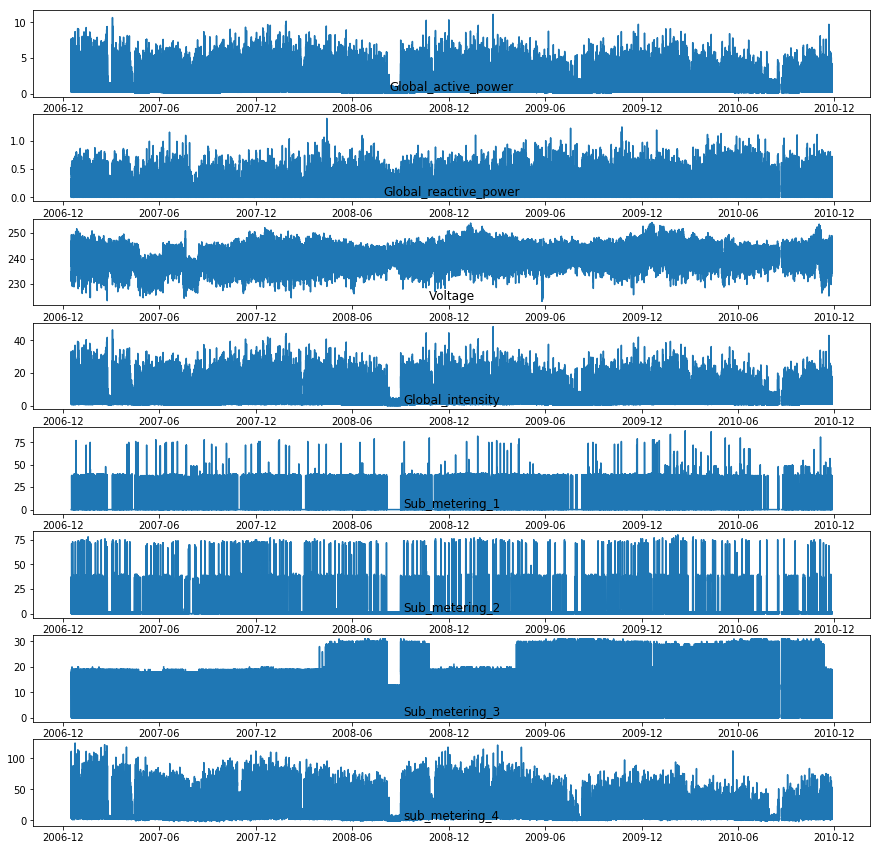

In [3]:
# Cargar los datos completos
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# Visualización de las variables
plt.figure(figsize=(15,15))
for i in range(len(dataset.columns)):
    
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    plt.plot(dataset[name])
    plt.title(name, y=0)
plt.show()

Para el presente trabajo se desea hacer predicciones sobre cada día de consumo, por lo tanto cambiaremos las medidas a un promedio obtenido de cada variable en un día.

In [4]:
# Remuestrear datos por dia
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# Resumen
print(daily_data.shape)
print(daily_data.head())
# Guardar archivo como un nuevo CSV
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

A continuación, se presentan las gráficas correspondientes al muestreo por día de cada variable.

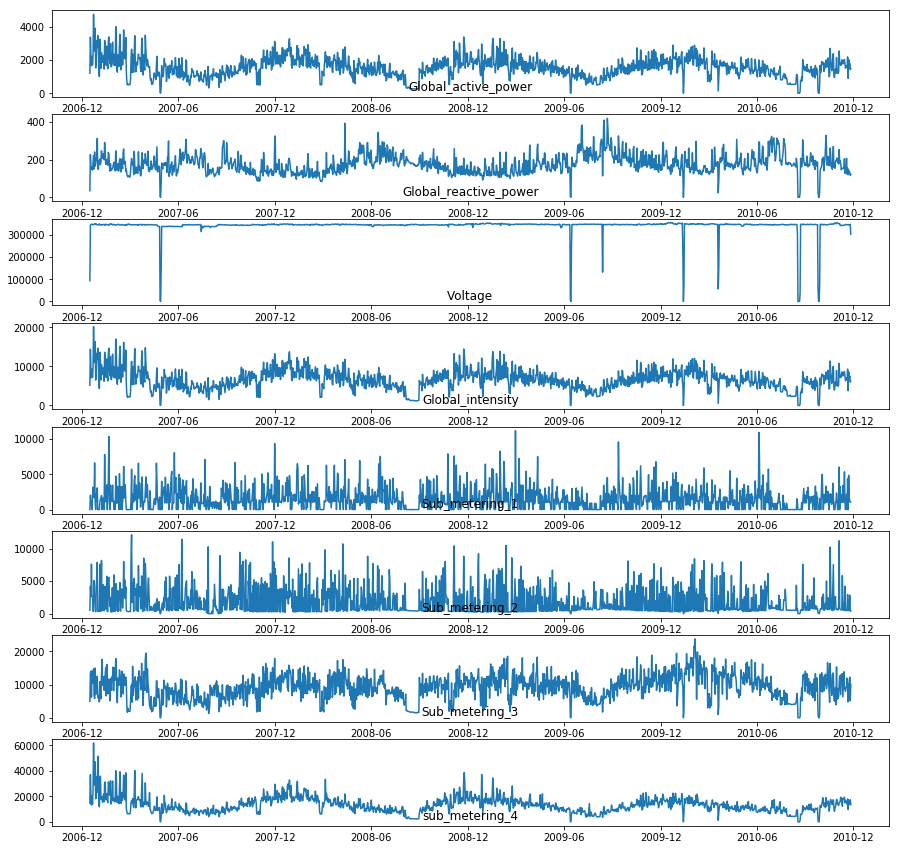

In [5]:
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# Visualización de las variables
plt.figure(figsize=(15,15))
for i in range(len(dataset.columns)):
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    plt.plot(dataset[name])
    plt.title(name, y=0)
plt.show()

## 2. Análisis:

- Podemos apreciar que el consumo global de la residencia tiene una tendencia que se presenta en un alza iniciando aproximadamente en el sexto mes y decayendo en los primeros meses del año, atribuimos estos cambios a las estaciones en París-Francia lugar donde se recopilaron los datos. 

- La potencia reactiva presenta las mismas tendencias del consumo global de la residencia. 

- La intensidad global también presenta una señal con tendencias a subir y bajar en las zonas correspondientes al consumo global.

- El voltaje presenta a lo largo de los años una tendencia estacionaria sin embargo se presentan ciertos picos a la baja, por su irregularidad asumimos que son fallas en el sistema de medición en esta variable.

- Las medidas de la energía tomadas por zonas de la residencia y la energía remanente presentan fluctuaciones muy fuertes que hacen difícil un análisis visual. Sin embargo, presenta pequeñas zonas donde se puede observar una marcada baja de las mediciones obtenidas y son regulares para las cuatro medidas, como en la zona intermedia del periodo correspondiente al 2006-12 y 2007-06. Estos *baches* tienen una correspondencia con las demás variables en estos mismos periodos de tiempo.


### División de los datos

Primero se van a tomar solo los valores numéricos del dataframe con la finalidad de tomarlos en un formato que sea comprensible para una red neuronal

In [6]:
dataset = dataset.values
dataset = dataset.astype('float32')
print("Type",type(dataset), "tamaño",dataset.shape)

Type <class 'numpy.ndarray'> tamaño (1442, 8)


Ahora es posible hacer la división de los datos, en este caso usaremos una proporción del 67% la longitud en el tiempo de la señal para el entrenamiento y el restante para el conjunto de evaluación.

Los datos requieren ser normalizados para evitar las diferencias entre escalas de las variables y mejorar la capacidad de las arquitecturas para generalizar un modelo.

In [7]:
# División de los datos
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print ("Antes de escalar")
print ("train",train.shape,"test",test.shape)
# normalización de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
trainN = scaler.fit_transform(train)
testN = scaler.transform(test)
print ("Despues de escalar")
print ("testN",testN.shape, "trainN",trainN.shape)

Antes de escalar
train (966, 8) test (476, 8)
Despues de escalar
testN (476, 8) trainN (966, 8)


### Función para modificar los pasos hacia atras

Para mejorar la eficiencia de las diferentes arquitecturas se usarán diferentes pasos de tiempo hacia atrás. La función que se presenta a continuación está en la capacidad de tomar tiempos hacia atrás y hacia adelante, en este proyecto usaremos pasos hacia atrás desde 1 hasta 30 días.

In [8]:
def create_datasetMultipleTimesBackAhead(dataset, n_steps_out=1, n_steps_in=1, overlap = 1,index_feature_pred = None):
    dataX, dataY = [], []
    tem = n_steps_in + n_steps_out - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        startx = i*overlap
        endx = startx + n_steps_in
        starty = endx
        endy = endx + n_steps_out
        a = dataset[startx:endx, :]
        dataX.append(a)
        dataY.append(dataset[starty:endy, index_feature_pred])
    return np.array(dataX), np.array(dataY)

Para evitar fallas en el llamado de los datos se ejecutara una función que haga la división de los datos entre entrenamiento y validación tanto para los datos de alimentación X como para sus correspondientes etiquetas Y

In [9]:
def crearXY(trainN,testN,n_steps_out,n_steps_in,overlap,index_feature_pred=0):
    X_train, y_train = create_datasetMultipleTimesBackAhead(trainN, n_steps_out, n_steps_in, overlap, index_feature_pred)
    X_test, y_test = create_datasetMultipleTimesBackAhead(testN, n_steps_out, n_steps_in, overlap, index_feature_pred)
    return X_train,y_train,X_test,y_test

## 3. Creando diferentes arquitecturas para evaluar el desempeño

En esta sección se crearán las arquitecturas RNN, LSTM y GRU con diferentes pasos de tiempo para evaluar su rendimiento. Para cada una de las arquitecturas se cambiarán los pasos hacia atrás para verificar el comportamiento del modelo.


### Función para comparar métricas de rendimiento
En esta sección se implementa una función que está encargada de comparar los diferentes resultados del MSE obtenido como métricas de rendimiento de las arquitecturas.


In [10]:
def plot_metrics_model(mse1,title,plt):
    plt.plot(mse1, lw=4, alpha=.5, label=title)
    plt.grid();
    plt.xlabel("Number of steps in")
    plt.ylabel("MSE")
    plt.title(title)
    plt.legend();
    plt.plot
    return plt

### Función de análisis grafico para el encoder
En esta sección se encuentra la función que permite observar el rendimiento de la arquitectura de auto encoder. La metrica seleccionada es el error cuadratico medio.


In [11]:
def plot_metrics_model_enco(mse1,title,plt):
    plt.plot(mse1, lw=4, alpha=.5, label=title)
    plt.grid();
    plt.xlabel("Number of steps in")
    plt.ylabel("MSE")
    plt.title(title)
    plt.legend();
    plt.plot
    return plt

### Arquitecturas 

A continuación se fabricaran las arquitecturas RNN, LSTM y GRU y se evaluaran los resultados desde 1 hasta 30 días como pasos hacia atrás


In [12]:
pasos=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

### RNN

In [13]:
def modeloRNN(X_train, y_train, X_test, n_steps=1):
    print ("X_train",X_train.shape)
    print ("y_train",y_train.shape[0])
    print ("n_steps",n_steps)
    
    n_features = (X_train.shape[2])
    model = Sequential()
    model.add(SimpleRNN(50,activation = 'relu',input_shape=(n_steps,n_features)))
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    model.fit(X_train,y_train[:,0].flatten(),epochs=100, verbose=1)
    
    mse = model.history.history["loss"][-1]
    
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    print("mse=",mse)
    return mse, trainPredict, testPredict, model

***Ajuste y predicción del modelo***

In [14]:
n_steps_out=1
overlap=1
mseP_rnn=[]
for i in pasos:
    n_steps_in=i
    print ("pasos",i)
    X_train1, y_train1, X_test1, y_test1 = crearXY (trainN, testN, n_steps_out, n_steps_in, overlap, index_feature_pred=0)
    mse1, trainPredict1, testPredict1,_ = modeloRNN(X_train1, y_train1, X_test1, n_steps_in)
    mseP_rnn += [mse1]

pasos 1
X_train (965, 1, 8)
y_train 965
n_steps 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
965/965 [==============================] - 6s 6ms/step - loss: 0.0270 - mean_absolute_error: 0.1277 - acc: 0.0021
Epoch 2/100
965/965 [==============================] - 0s 139us/step - loss: 0.0152 - mean_absolute_error: 0.0934 - acc: 0.0021
Epoch 3/100
965/965 [==============================] - 0s 152us/step - loss: 0.0131 - mean_absolute_error: 0.0862 - acc: 0.0021
Epoch 4/100
965/965 [==============================] - 0s 168us/step - loss: 0.0121 - mean_absolute_error: 0.0823 - acc: 0.0021
Epoch 5/100
965/965 [==============================] - 0s 200us/step - loss: 0.0117 - mean_absolute_error: 0.0799 - acc: 0.0021
Epoch 6/100
965/965 [==============================] - 0s 161us/step - loss: 0.0115 - mean_absolute_error: 0.0801 - acc: 0.0021
Epoch 7/100
965/965 [==============================] - 0s 169us/

### Graficas

**Error cuadratico medio con diferentes pasos hacia atrás**

<module 'matplotlib.pyplot' from 'C:\\Users\\Jose\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

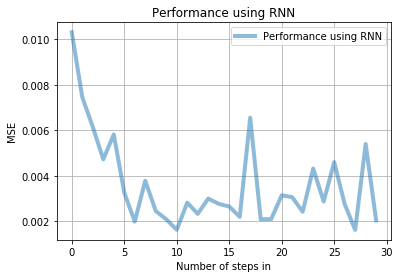

In [15]:
plot_metrics_model(mseP_rnn,"Performance using RNN",plt)

**Graficas de ajuste del modelo**

In [16]:
print(dataset.shape)
print(trainPredict1.shape)
print(testPredict1.shape)

(1442, 8)
(936, 1)
(446, 1)


In [17]:
consumoG = scaler.fit_transform(dataset[:,0].reshape(-1, 1))
consumoG.shape

(1442, 1)

936
446
446


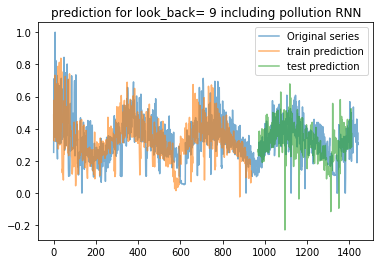

In [18]:
n_steps=30
x_lab1=[]
for i in range(consumoG.shape[0]):
    x_lab1 += [i]

x_lab2=[]
for i in range(len(trainPredict1)):
    x_lab2 += [i]

x_lab3=[]
for i in range(len(trainPredict1)+n_steps,len(testPredict1)+len(trainPredict1)+n_steps):
    x_lab3 += [i]

print(len(trainPredict1))
print(len(testPredict1))
print(len(x_lab3))
  
plt.plot(x_lab1,consumoG, alpha=0.6, label='Original series');
plt.plot(x_lab2,trainPredict1,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict1, alpha=0.6, label='test prediction');
plt.title("prediction for look_back= 9 including pollution RNN")
plt.legend();

### LSTM

In [19]:
def modeloLSTM(X_train,y_train,X_test,n_steps=1):
    print ("X_train",X_train.shape)
    print ("y_train",y_train.shape[0])
    print ("n_steps",n_steps)
    n_features=(X_train.shape[2])
    #n_steps=n_steps_in
    model = Sequential()
    model.add(LSTM(50,activation = 'relu',input_shape=(n_steps,n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    model.fit(X_train,y_train[:,0].flatten(),epochs=100, verbose=1)
    mse = model.history.history["loss"][-1]
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    return mse, trainPredict, testPredict, model

***Ajuste y predicción del modelo***

In [20]:
n_steps_out=1
overlap=1
mseP_LSTM=[]
for i in pasos:
    n_steps_in=i
    print ("pasos",i)
    X_train2, y_train2, X_test2, y_test2 = crearXY (trainN, testN, n_steps_out, n_steps_in, overlap, index_feature_pred=0)
    mse3, trainPredict3, testPredict3,_ = modeloLSTM(X_train2, y_train2, X_test2, n_steps_in)
    mseP_LSTM += [mse3]
    

pasos 1
X_train (965, 1, 8)
y_train 965
n_steps 1
Epoch 1/100
965/965 [==============================] - 3s 3ms/step - loss: 0.0890 - mean_absolute_error: 0.2608 - acc: 0.0021
Epoch 2/100
965/965 [==============================] - ETA: 0s - loss: 0.0184 - mean_absolute_error: 0.1038 - acc: 0.0025e+0 - ETA: 0s - loss: 0.0210 - mean_absolute_error: 0.1132 - acc: 0.0024  - 0s 265us/step - loss: 0.0180 - mean_absolute_error: 0.1031 - acc: 0.0021
Epoch 3/100
965/965 [==============================] - 0s 278us/step - loss: 0.0138 - mean_absolute_error: 0.0934 - acc: 0.0021
Epoch 4/100
965/965 [==============================] - 0s 219us/step - loss: 0.0134 - mean_absolute_error: 0.0891 - acc: 0.0021
Epoch 5/100
965/965 [==============================] - 0s 221us/step - loss: 0.0128 - mean_absolute_error: 0.0875 - acc: 0.0021
Epoch 6/100
965/965 [==============================] - 0s 249us/step - loss: 0.0124 - mean_absolute_error: 0.0850 - acc: 0.0021
Epoch 7/100
965/965 [=====================

### Graficas

**Error cuadratico medio con diferentes pasos hacia atrás**

<module 'matplotlib.pyplot' from 'C:\\Users\\Jose\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

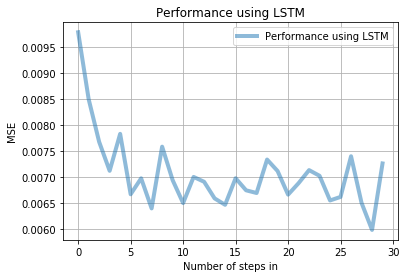

In [21]:
plot_metrics_model(mseP_LSTM, "Performance using LSTM", plt)

**Graficas de ajuste del modelo**

936
446
438


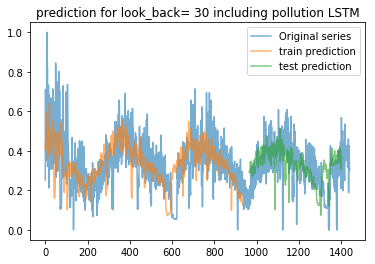

In [22]:
n_steps=30
x_lab1=[]
for i in range(consumoG.shape[0]):
    x_lab1 += [i]
    
x_lab2=[]
for i in range(len(trainPredict1)):
    x_lab2 += [i]

x_lab3=[]
for i in range(len(trainPredict1)+n_steps,len(testPredict1)+len(trainPredict1)+n_steps-8):
    x_lab3 += [i]

print(len(trainPredict1))
print(len(testPredict1))
print(len(x_lab3))
  
plt.plot(x_lab1,consumoG, alpha=0.6, label='Original series');
plt.plot(x_lab2,trainPredict3,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict3[8:,:], alpha=0.6, label='test prediction');
plt.title("prediction for look_back= 30 including pollution LSTM")
plt.legend();

### GRU

In [23]:
def modeloGRU(X_train,y_train,X_test,n_steps=1):
    print ("X_train",X_train.shape)
    print ("y_train",y_train.shape[0])
    print ("n_steps",n_steps)
    n_features=(X_train.shape[2])
    model = Sequential()
    model.add(GRU(50,activation = 'relu',input_shape=(n_steps,n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    model.fit(X_train,y_train[:,0].flatten(),epochs=100, verbose=1)
    mse = model.history.history["loss"][-1]
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    return mse, trainPredict, testPredict, model

***Ajuste y predicción del modelo***

In [24]:
n_steps_out=1
overlap=1
mseP_GRU=[]
for i in pasos:
    n_steps_in=i
    print (i)
    X_train3, y_train3, X_test3, y_test3 = crearXY (trainN,testN, n_steps_out,n_steps_in, overlap, index_feature_pred=0)
    mse5, trainPredict5, testPredict5,_ = modeloGRU(X_train3, y_train3, X_test3, n_steps_in)
    mseP_GRU += [mse5]
    

1
X_train (965, 1, 8)
y_train 965
n_steps 1
Epoch 1/100
965/965 [==============================] - ETA: 1s - loss: 0.0714 - mean_absolute_error: 0.2267 - acc: 0.0013 - 7s 7ms/step - loss: 0.0618 - mean_absolute_error: 0.2044 - acc: 0.0021
Epoch 2/100
965/965 [==============================] - 0s 250us/step - loss: 0.0156 - mean_absolute_error: 0.0976 - acc: 0.0021
Epoch 3/100
965/965 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0920 - acc: 0.0023   - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0919 - acc: 0.00 - 0s 270us/step - loss: 0.0140 - mean_absolute_error: 0.0914 - acc: 0.0021
Epoch 4/100
965/965 [==============================] - 0s 296us/step - loss: 0.0133 - mean_absolute_error: 0.0890 - acc: 0.0021
Epoch 5/100
965/965 [==============================] - 0s 295us/step - loss: 0.0127 - mean_absolute_error: 0.0874 - acc: 0.0021ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0881 - acc: 0.0000e
Epoch 6/100
965/965 [=======================

### Graficas

**Error cuadratico medio con diferentes pasos hacia atrás**

<module 'matplotlib.pyplot' from 'C:\\Users\\Jose\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

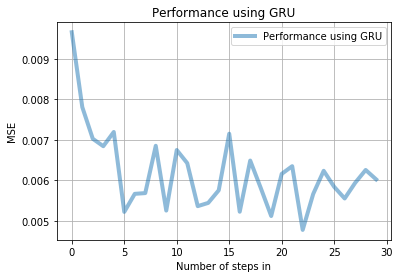

In [25]:
plot_metrics_model(mseP_GRU, "Performance using GRU", plt)

**Graficas de ajuste del modelo**

936
446
446


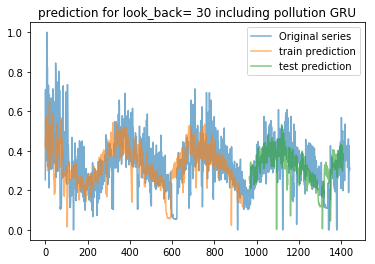

In [26]:
n_steps=30
x_lab1=[]
for i in range(consumoG.shape[0]):
    x_lab1 += [i]

x_lab2=[]
for i in range(len(trainPredict1)):
    x_lab2.append(i)

x_lab3=[]
for i in range(len(trainPredict1)+n_steps,len(testPredict1)+len(trainPredict1)+n_steps):
    x_lab3.append(i)
  
    
print(len(trainPredict1))
print(len(testPredict1))
print(len(x_lab3))
  
plt.plot(x_lab1,consumoG, alpha=0.6, label='Original series');
plt.plot(x_lab2,trainPredict5,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict5, alpha=0.6, label='test prediction');
plt.title("prediction for look_back= 30 including pollution GRU")
plt.legend();

## Encoder

### Encoder RNN

In [27]:
def enco_modeloRNN(X_train, y_train, X_test, n_steps=1):
    print ("X_train",X_train.shape)
    print ("y_train",y_train.shape[0])
    print ("n_steps",n_steps)
    
    n_features = (X_train.shape[2])
    
    model = Sequential()
    model.add(SimpleRNN(50,activation = 'relu',input_shape=(n_steps,n_features)))
    model.add(RepeatVector(n_steps))
    model.add(SimpleRNN(10,activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    model.fit(X_train,y_train[:,0].flatten(),epochs=100, verbose=1)
    
    mse = model.history.history["loss"][-1]
    
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    
    return mse,trainPredict, testPredict

***Ajuste y predicción del modelo***

In [28]:
n_steps_out=1
overlap=1
enco_mseP_rnn=[]
enco_mseWP_rnn=[]

for i in pasos:
    
    n_steps_in=i
    print (i)
    
    X_train7, y_train7, X_test7, y_test7 = crearXY (trainN, testN, n_steps_out, n_steps_in, overlap, index_feature_pred=0)
    mse7, trainPredict7, testPredict7 = enco_modeloRNN(X_train7, y_train7, X_test7, n_steps_in)
        
    enco_mseP_rnn  += [mse7]

1
X_train (965, 1, 8)
y_train 965
n_steps 1
Epoch 1/100
965/965 [==============================] - 10s 10ms/step - loss: 0.1420 - mean_absolute_error: 0.3094 - acc: 0.0021
Epoch 2/100
965/965 [==============================] - 0s 243us/step - loss: 0.0135 - mean_absolute_error: 0.0918 - acc: 0.0021
Epoch 3/100
965/965 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0791 - acc: 0.0023  - 0s 256us/step - loss: 0.0113 - mean_absolute_error: 0.0783 - acc: 0.0021
Epoch 4/100
965/965 [==============================] - 0s 265us/step - loss: 0.0108 - mean_absolute_error: 0.0771 - acc: 0.0021
Epoch 5/100
965/965 [==============================] - 0s 236us/step - loss: 0.0106 - mean_absolute_error: 0.0759 - acc: 0.0021
Epoch 6/100
965/965 [==============================] - 0s 254us/step - loss: 0.0105 - mean_absolute_error: 0.0748 - acc: 0.0021
Epoch 7/100
965/965 [==============================] - 0s 241us/step - loss: 0.0104 - mean_absolute_error: 0.0746 - ac

### Graficas

**Error cuadratico medio con diferentes pasos hacia atrás**

<module 'matplotlib.pyplot' from 'C:\\Users\\Jose\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

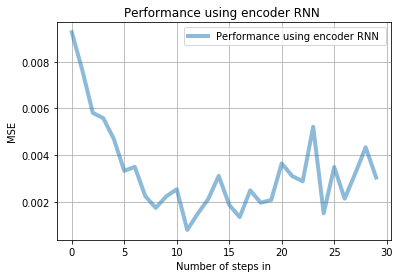

In [29]:
plot_metrics_model_enco(enco_mseP_rnn,"Performance using encoder RNN ",plt)

**Graficas de ajuste del modelo**

936
446
446


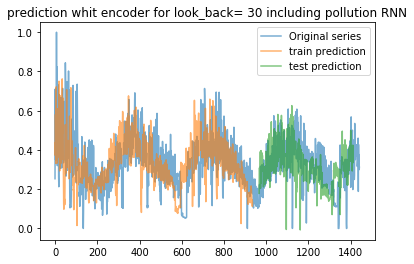

In [30]:
n_steps=30
x_lab1=[]
for i in range(consumoG.shape[0]):
    x_lab1 += [i]

x_lab2=[]
for i in range(len(trainPredict1)):
    x_lab2 += [i]

x_lab3=[]
for i in range(len(trainPredict1)+n_steps,len(testPredict1)+len(trainPredict1)+n_steps):
    x_lab3 += [i]

print(len(trainPredict1))
print(len(testPredict1))
print(len(x_lab3))
  
plt.plot(x_lab1,consumoG, alpha=0.6, label='Original series');
plt.plot(x_lab2,trainPredict7,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict7, alpha=0.6, label='test prediction');
plt.title("prediction whit encoder for look_back= 30 including pollution RNN")
plt.legend();

### Encoder LSTM

In [31]:
def enco_modeloLSTM(X_train, y_train, X_test, n_steps=1):
    print ("X_train",X_train.shape)
    print ("y_train",y_train.shape[0])
    print ("n_steps",n_steps)
    
    n_features = (X_train.shape[2])
    
    model = Sequential()
    model.add(LSTM(50,activation = 'relu',input_shape=(n_steps,n_features)))
    model.add(RepeatVector(n_steps))
    model.add(LSTM(10,activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    model.fit(X_train,y_train[:,0].flatten(),epochs=100, verbose=1)
    
    mse = model.history.history["loss"][-1]
    
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    
    return mse,trainPredict, testPredict

***Ajuste y predicción del modelo***

In [32]:
n_steps_out=1
overlap=1
enco_mseP_LSTM=[]


for i in pasos:
    
    n_steps_in=i
    print (i)
    
    X_train8, y_train8, X_test8, y_test8 = crearXY (trainN, testN, n_steps_out, n_steps_in, overlap, index_feature_pred=0)
    mse8, trainPredict8, testPredict8 = enco_modeloRNN(X_train8, y_train8, X_test8, n_steps_in)
        
    enco_mseP_LSTM  += [mse8]

1
X_train (965, 1, 8)
y_train 965
n_steps 1
Epoch 1/100
965/965 [==============================] - 10s 11ms/step - loss: 0.0611 - mean_absolute_error: 0.1930 - acc: 0.0021
Epoch 2/100
965/965 [==============================] - 0s 435us/step - loss: 0.0140 - mean_absolute_error: 0.0887 - acc: 0.0021
Epoch 3/100
965/965 [==============================] - 0s 313us/step - loss: 0.0118 - mean_absolute_error: 0.0826 - acc: 0.0021
Epoch 4/100
965/965 [==============================] - 0s 343us/step - loss: 0.0113 - mean_absolute_error: 0.0785 - acc: 0.0021ETA: 0s - loss: 0.0121 - mean_absolute_error: 0.0804 - acc: 0.0000e
Epoch 5/100
965/965 [==============================] - 0s 272us/step - loss: 0.0110 - mean_absolute_error: 0.0778 - acc: 0.0021
Epoch 6/100
965/965 [==============================] - 0s 308us/step - loss: 0.0106 - mean_absolute_error: 0.0765 - acc: 0.0021
Epoch 7/100
965/965 [==============================] - 0s 343us/step - loss: 0.0103 - mean_absolute_error: 0.0750 - acc: 

### Graficas

**Error cuadratico medio con diferentes pasos hacia atrás**

<module 'matplotlib.pyplot' from 'C:\\Users\\Jose\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

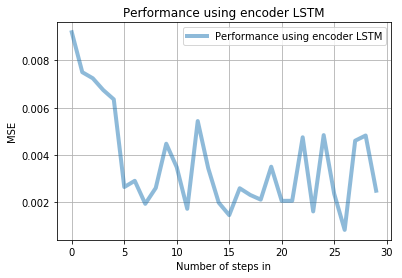

In [33]:
plot_metrics_model_enco(enco_mseP_LSTM,"Performance using encoder LSTM",plt)

**Graficas de ajuste del modelo**

936
446
446


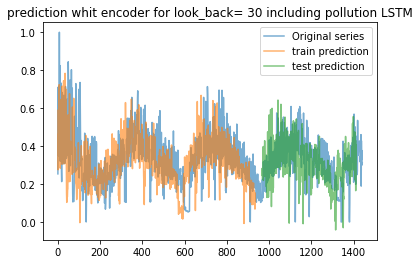

In [34]:
n_steps=30
x_lab1=[]
for i in range(consumoG.shape[0]):
    x_lab1 += [i]

x_lab2=[]
for i in range(len(trainPredict1)):
    x_lab2 += [i]

x_lab3=[]
for i in range(len(trainPredict1)+n_steps,len(testPredict1)+len(trainPredict1)+n_steps):
    x_lab3 += [i]

print(len(trainPredict1))
print(len(testPredict1))
print(len(x_lab3))
  
plt.plot(x_lab1,consumoG, alpha=0.6, label='Original series');
plt.plot(x_lab2,trainPredict8,alpha=0.6, label='train prediction');
plt.plot(x_lab3,testPredict8, alpha=0.6, label='test prediction');
plt.title("prediction whit encoder for look_back= 30 including pollution LSTM")
plt.legend();

### Encoder GRU

In [35]:
def enco_modeloGRU(X_train, y_train, X_test, n_steps=1):
    print ("X_train",X_train.shape)
    print ("y_train",y_train.shape[0])
    print ("n_steps",n_steps)
    
    n_features = (X_train.shape[2])
    
    model = Sequential()
    model.add(GRU(50,activation = 'relu',input_shape=(n_steps,n_features)))
    model.add(RepeatVector(n_steps))
    model.add(GRU(10,activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse', metrics=['mae', 'acc'])
    model.fit(X_train,y_train[:,0].flatten(),epochs=100, verbose=1)
    
    mse = model.history.history["loss"][-1]
    
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    
    return mse,trainPredict, testPredict

***Ajuste y predicción del modelo***

In [36]:
n_steps_out=1
overlap=1
enco_mseP_GRU=[]


for i in pasos:
    
    n_steps_in=i
    print (i)
    
    X_train9, y_train9, X_test9, y_test9 = crearXY (trainN, testN, n_steps_out, n_steps_in, overlap, index_feature_pred=0)
    mse9, trainPredict9, testPredict9 = enco_modeloRNN(X_train9, y_train9, X_test9, n_steps_in)
        
    enco_mseP_GRU  += [mse9]

1
X_train (965, 1, 8)
y_train 965
n_steps 1
Epoch 1/100
965/965 [==============================] - 14s 15ms/step - loss: 0.2666 - mean_absolute_error: 0.4556 - acc: 0.0021
Epoch 2/100
965/965 [==============================] - 1s 594us/step - loss: 0.0266 - mean_absolute_error: 0.1233 - acc: 0.0021
Epoch 3/100
965/965 [==============================] - 0s 430us/step - loss: 0.0123 - mean_absolute_error: 0.0838 - acc: 0.0021
Epoch 4/100
965/965 [==============================] - 1s 839us/step - loss: 0.0108 - mean_absolute_error: 0.0780 - acc: 0.0021ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.0835 - acc: 0.0022
Epoch 5/100
965/965 [==============================] - 0s 390us/step - loss: 0.0107 - mean_absolute_error: 0.0774 - acc: 0.0021
Epoch 6/100
965/965 [==============================] - 0s 343us/step - loss: 0.0104 - mean_absolute_error: 0.0757 - acc: 0.0021
Epoch 7/100
965/965 [==============================] - 0s 339us/step - loss: 0.0107 - mean_absolute_error: 0.0775 - acc: 0

### Graficas

**Error cuadratico medio con diferentes pasos hacia atrás**

<module 'matplotlib.pyplot' from 'C:\\Users\\Jose\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

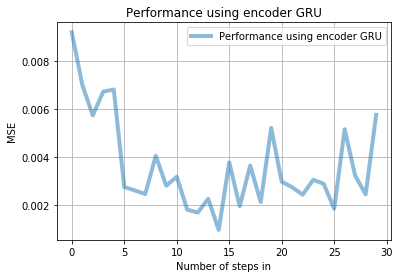

In [37]:
plot_metrics_model_enco(enco_mseP_GRU,"Performance using encoder GRU",plt)

**Graficas de ajuste del modelo**

936
446
454


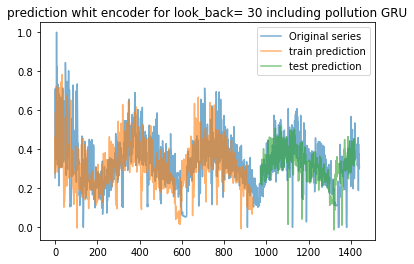

In [38]:
n_steps=30
x_lab1=[]
for i in range(consumoG.shape[0]):
    x_lab1 += [i]
    
x_lab2=[]
for i in range(len(trainPredict1)):
    x_lab2 += [i]

x_lab3=[]
for i in range(len(trainPredict1)+n_steps,len(testPredict1)+len(trainPredict1)+n_steps+8):
    x_lab3 += [i]

print(len(trainPredict1))
print(len(testPredict1))
print(len(x_lab3))
  
plt.plot(x_lab1,consumoG, alpha=0.6, label='Original series');
plt.plot(x_lab2,trainPredict8,alpha=0.6, label='train prediction');
plt.plot(x_lab3[8:],testPredict9, alpha=0.6, label='test prediction');
plt.title("prediction whit encoder for look_back= 30 including pollution GRU")
plt.legend();

## 4. Graficas comparativas entre modelos 

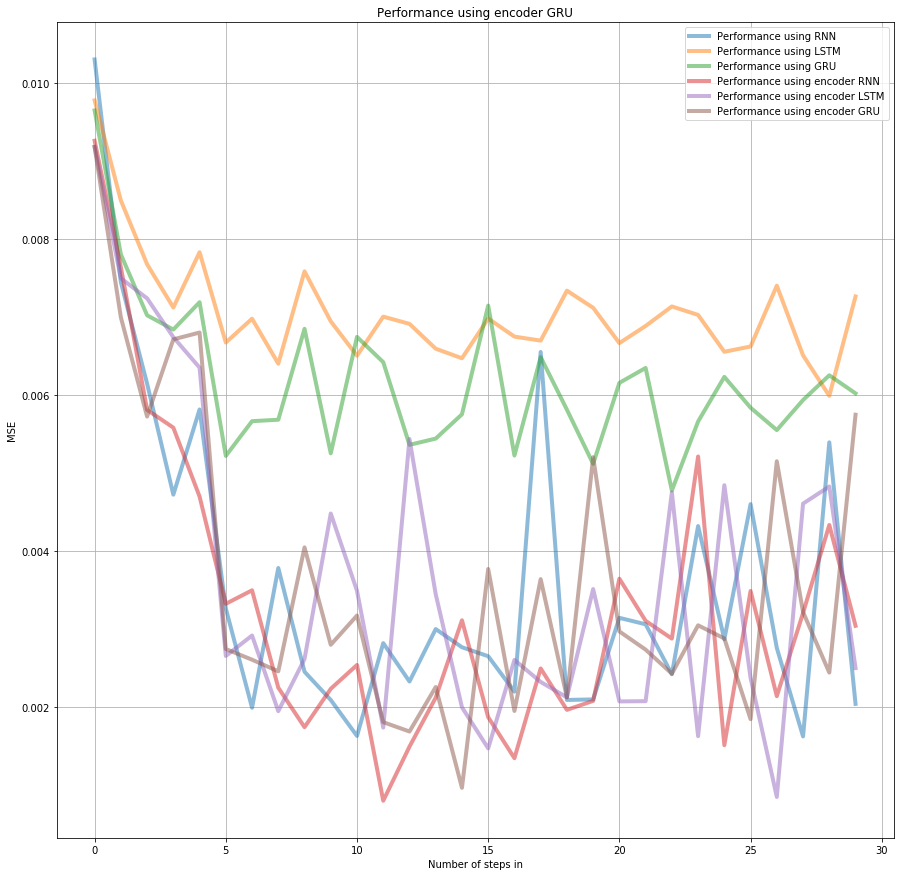

In [39]:
plt.figure(figsize=(15,15))
plot_metrics_model(mseP_rnn,"Performance using RNN",plt)
plot_metrics_model(mseP_LSTM, "Performance using LSTM", plt)
plot_metrics_model(mseP_GRU, "Performance using GRU", plt)
plot_metrics_model_enco(enco_mseP_rnn,"Performance using encoder RNN ",plt)
plot_metrics_model_enco(enco_mseP_LSTM,"Performance using encoder LSTM",plt)
plot_metrics_model_enco(enco_mseP_GRU,"Performance using encoder GRU",plt)
plt.grid()

## 5. Conclusiones:

- Las arquitecturas evaluadas presentan una respuesta fluctuante en su medida de MSE similar a una señal diente de sierra. Las arquitecturas basadas en encoder lograron un menor MSE.

- Las arquitecturas basadas en encoder de RNN y GRU presentan el menor MSE. Sin embargo, los valores se alcanzan con valores de pasos hacia atrás diferentes. La arquitectura RNN logra el mismo rendimiento con 11 pasos, entre tanto la arquitectura GRU lo hace con 26 pasos.

- El usar pasos hacia atrás mejora la capacidad de generalización de una red neuronal. Sin embargo, requiere eliminar datos que no pueden ser usados para el análisis. Si bien en este caso no representa una pérdida de información representativa es un elemento a considerar para preferir el uso de una red RNN sobre una GRU.
